In [1]:
import numpy as np
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
# https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

def squeeze_answer_matrix(matrix: np.array):
    return list(
        map(
            lambda x: np.array(list(filter(lambda y: not np.isnan(y), x))),
            matrix.tolist()
        )
    )

def get_exact_match_ratio(m_true, m_pred):
    correct = 0
    total = len(m_pred)
    for _pred, _true in zip(m_pred, m_true):
        if np.all(_pred == _true):
            correct += 1

    return correct / total

def get_accuracy(m_true, m_pred):
    acc = 0
    total = len(m_pred)
    for _pred, _true in zip(m_pred, m_true):
        numerator = sum(np.logical_and(_true, _pred))
        denominator = sum(np.logical_or(_true, _pred))
        acc +=  numerator / denominator if denominator != 0 else 1

    return acc / total

In [3]:
# Загружаем предвычесленные фичи
OPENMIC = np.load('data/openmic-2018/openmic-2018.npz', allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

# Загружаем словарь-маппер инструментов
with open('data/openmic-2018/class-map.json', 'r') as f:
    instrument_to_idx = json.load(f)

idx_to_instrument = { value:key for key, value in instrument_to_idx.items()}

# Создатели open-mic-2018 разделили на тренировочную и тестовые выборки по 14915 и 5085 соответственно
split_train = set(pd.read_csv('data/openmic-2018/partitions/split01_train.csv',
                          header=None).squeeze())

split_test = set(pd.read_csv('data/openmic-2018/partitions/split01_test.csv',
                         header=None).squeeze())

train_set = set(split_train)
test_set = set(split_test)

idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))

# Получаем индексы, по которым будем делить данные
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

# Sample[n] : timestamp[10] : features[128]
X_train = X[idx_train]
X_test = X[idx_test]

# Sample[n] : Уверенности в наличие инструмента[20]
Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

# Sample[n] : Известно ли наличие инструмента[20]
Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [21]:
for instrument in instrument_to_idx:
    inst_num = instrument_to_idx[instrument]

    test_inst = Y_mask_test[:, inst_num]
    zxc = test_inst.nonzero()
    break

(538,) 538


In [165]:
def classify(classifier):
    models = dict()

    # Трешхолд уверенности в наличии инструмента
    treshold = 0.5

    # Создаем матрицы для подсчета глобальных метрик
    train_true_matrix = np.empty(Y_true_train.shape)
    train_true_matrix[:] = np.nan
    train_pred_matrix = np.empty(Y_true_train.shape)
    train_pred_matrix[:] = np.nan


    test_true_matrix = np.empty(Y_true_test.shape)
    test_true_matrix[:] = np.nan
    test_pred_matrix = np.empty(Y_true_test.shape)
    test_pred_matrix[:] = np.nan

    train_conf_matrices = []
    test_conf_matrices = []

    # Проходим по всем инструментам
    for instrument in instrument_to_idx:

        # Выбираем id инструмента
        inst_num = instrument_to_idx[instrument]

        # Получаем маску для инструментов
        train_inst = Y_mask_train[:, inst_num]
        test_inst = Y_mask_test[:, inst_num]

        # Выбираем только те x и y, в которых было измерено наличие или отсутствие инструмента
        X_train_inst = X_train[train_inst]
        X_test_inst = X_test[test_inst]

        # Если confidence в инструменте >0.5, то считаем что он есть в песне
        Y_true_train_inst = Y_true_train[train_inst, inst_num] >= treshold
        Y_true_test_inst = Y_true_test[test_inst, inst_num] >= treshold

        train_instrument_indices = train_inst.nonzero()
        test_instrument_indices = test_inst.nonzero()

        # Усредняем массив vggish фичей для получения 1 вектора вместо time-varying
        X_train_inst_avg = np.mean(X_train_inst, axis=1)
        X_test_inst_avg = np.mean(X_test_inst, axis=1)

        # Инициализируем классификатор
        clf = classifier

        # Обучаем
        clf.fit(X_train_inst_avg, Y_true_train_inst)

        # Сохраняем модель
        models[instrument] = clf

        # Предсказываем трейн и тест
        Y_pred_train = clf.predict(X_train_inst_avg)
        Y_pred_test = clf.predict(X_test_inst_avg)

        # Заполняем матрицу ответов классификатора
        train_true_matrix[train_instrument_indices, inst_num] = Y_true_train_inst
        train_pred_matrix[train_instrument_indices, inst_num] = Y_pred_train

        test_true_matrix[test_instrument_indices, inst_num] = Y_true_test_inst
        test_pred_matrix[test_instrument_indices, inst_num] = Y_pred_test

        # Строим classification_report для тренировочного и тестового датасета
        print('-' * 52)
        print(instrument)


        print('\tTRAIN')
        train_conf_matrices.append(confusion_matrix(Y_true_train_inst, Y_pred_train))
        print(classification_report(Y_true_train_inst, Y_pred_train, zero_division=0))


        print('\tTEST')
        test_conf_matrices.append(confusion_matrix(Y_true_test_inst, Y_pred_test))
        print(classification_report(Y_true_test_inst, Y_pred_test, zero_division=0))

    return models, \
        train_conf_matrices, \
        test_conf_matrices, \
        train_true_matrix, \
        train_pred_matrix, \
        test_true_matrix, \
        test_pred_matrix

In [162]:
classifier = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)
models, \
    train_conf_matrices, \
    test_conf_matrices, \
    train_true_matrix, \
    train_pred_matrix, \
    test_true_matrix, \
    test_pred_matrix = classify(classifier)

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1159
        True       1.00      0.88      0.94       374

    accuracy                           0.97      1533
   macro avg       0.98      0.94      0.96      1533
weighted avg       0.97      0.97      0.97      1533

	TEST
              precision    recall  f1-score   support

       False       0.84      0.97      0.90       423
        True       0.77      0.32      0.45       115

    accuracy                           0.83       538
   macro avg       0.81      0.65      0.68       538
weighted avg       0.83      0.83      0.81       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1148
        True       0.97      0.97      0.97       592

    accuracy                           0

In [163]:
print('TRAIN')
m1 = squeeze_answer_matrix(train_true_matrix)
m2 = squeeze_answer_matrix(train_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

print('TEST')
m1 = squeeze_answer_matrix(test_true_matrix)
m2 = squeeze_answer_matrix(test_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TRAIN
Exact Match Ratio 0.9362386858866912
Accuracy 0.9506145938093635
TEST
Exact Match Ratio 0.7061946902654868
Accuracy 0.7508292363159618


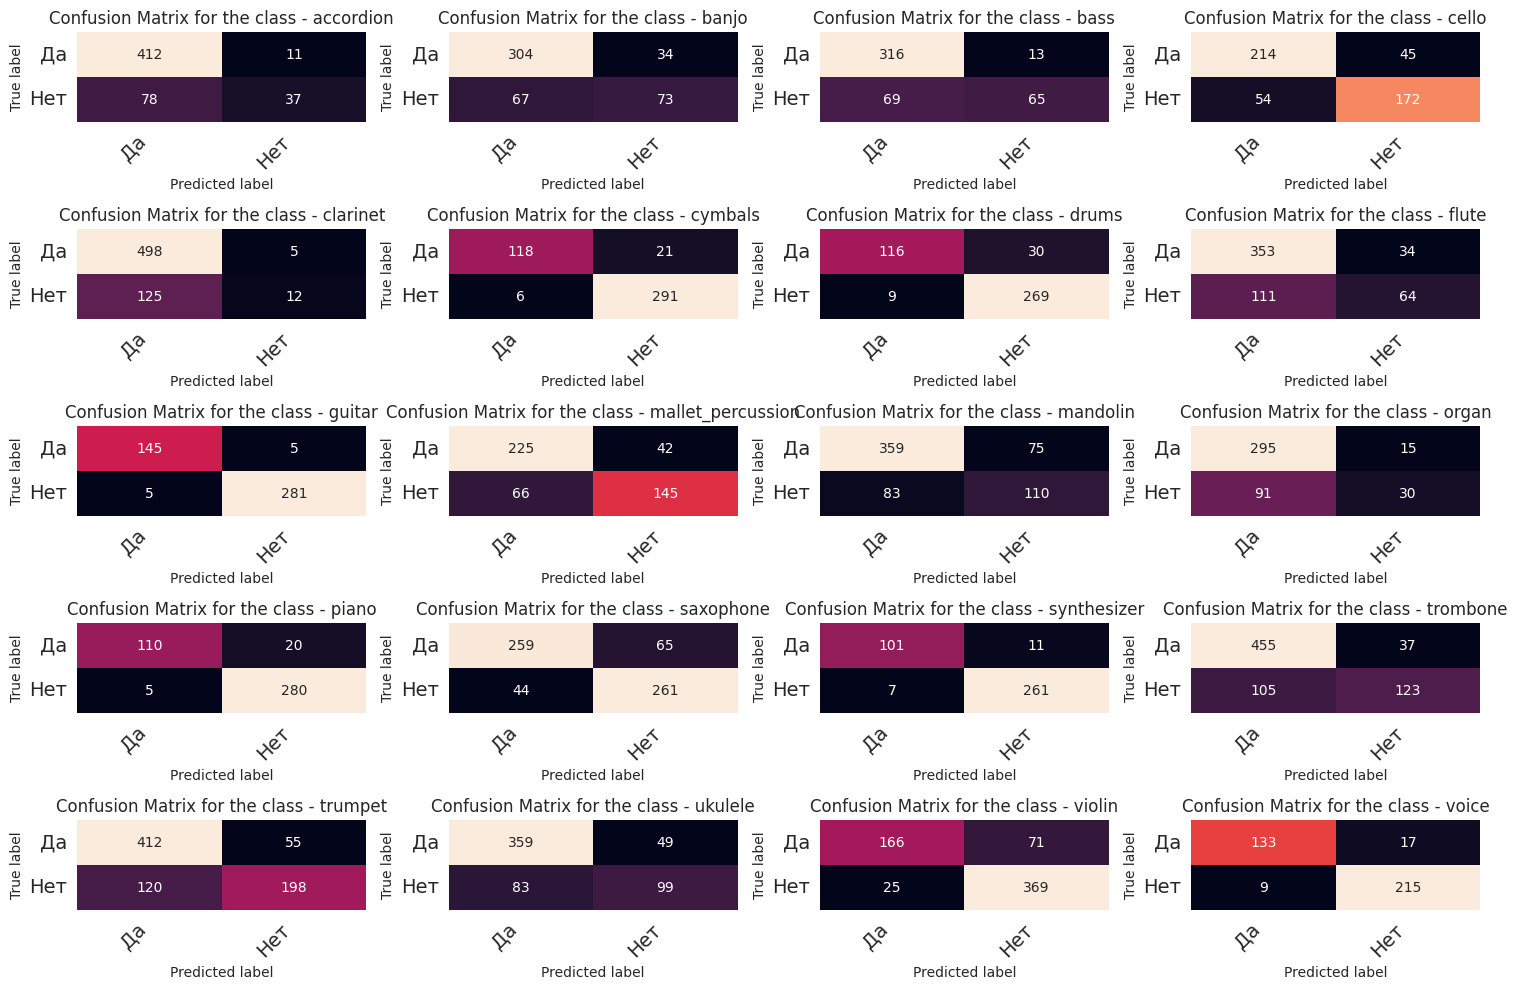

In [157]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = test_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

In [192]:
from sklearn.svm import SVC

classifier = SVC(gamma='auto')
models, \
    train_conf_matrices, \
    test_conf_matrices, \
    train_true_matrix, \
    train_pred_matrix, \
    test_true_matrix, \
    test_pred_matrix = classify(classifier)

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1159
        True       1.00      1.00      1.00       374

    accuracy                           1.00      1533
   macro avg       1.00      1.00      1.00      1533
weighted avg       1.00      1.00      1.00      1533

	TEST
              precision    recall  f1-score   support

       False       0.79      1.00      0.88       423
        True       0.00      0.00      0.00       115

    accuracy                           0.79       538
   macro avg       0.39      0.50      0.44       538
weighted avg       0.62      0.79      0.69       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1148
        True       1.00      1.00      1.00       592

    accuracy                           1

In [193]:
print('TRAIN')
m1 = squeeze_answer_matrix(train_true_matrix)
m2 = squeeze_answer_matrix(train_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

print('TEST')
m1 = squeeze_answer_matrix(test_true_matrix)
m2 = squeeze_answer_matrix(test_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TRAIN
Exact Match Ratio 1.0
Accuracy 1.0
TEST
Exact Match Ratio 0.5034414945919371
Accuracy 0.564768928220256


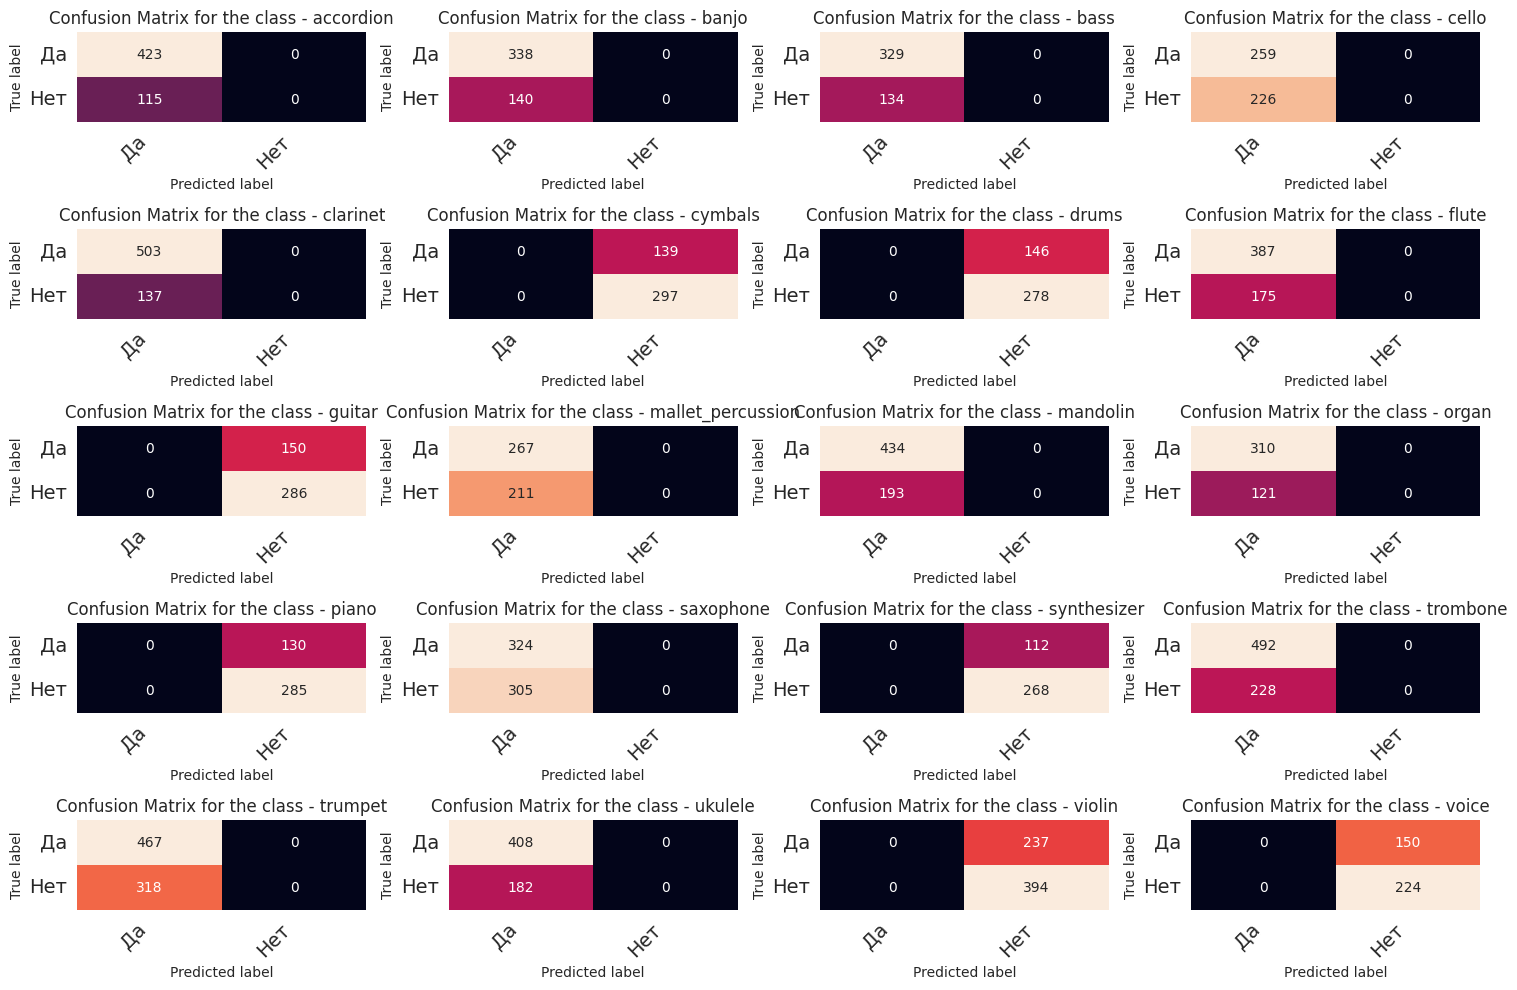

In [194]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = test_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

In [195]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=100, random_state=0)

models, \
    train_conf_matrices, \
    test_conf_matrices, \
    train_true_matrix, \
    train_pred_matrix, \
    test_true_matrix, \
    test_pred_matrix = classify(classifier)

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      1159
        True       0.90      0.84      0.87       374

    accuracy                           0.94      1533
   macro avg       0.93      0.90      0.91      1533
weighted avg       0.94      0.94      0.94      1533

	TEST
              precision    recall  f1-score   support

       False       0.85      0.87      0.86       423
        True       0.49      0.44      0.46       115

    accuracy                           0.78       538
   macro avg       0.67      0.66      0.66       538
weighted avg       0.77      0.78      0.78       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.92      0.93      0.92      1148
        True       0.86      0.84      0.85       592

    accuracy                           0

In [196]:
print('TRAIN')
m1 = squeeze_answer_matrix(train_true_matrix)
m2 = squeeze_answer_matrix(train_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

print('TEST')
m1 = squeeze_answer_matrix(test_true_matrix)
m2 = squeeze_answer_matrix(test_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TRAIN
Exact Match Ratio 0.8609453570231311
Accuracy 0.8924058554028372
TEST
Exact Match Ratio 0.6617502458210422
Accuracy 0.7183284169124873


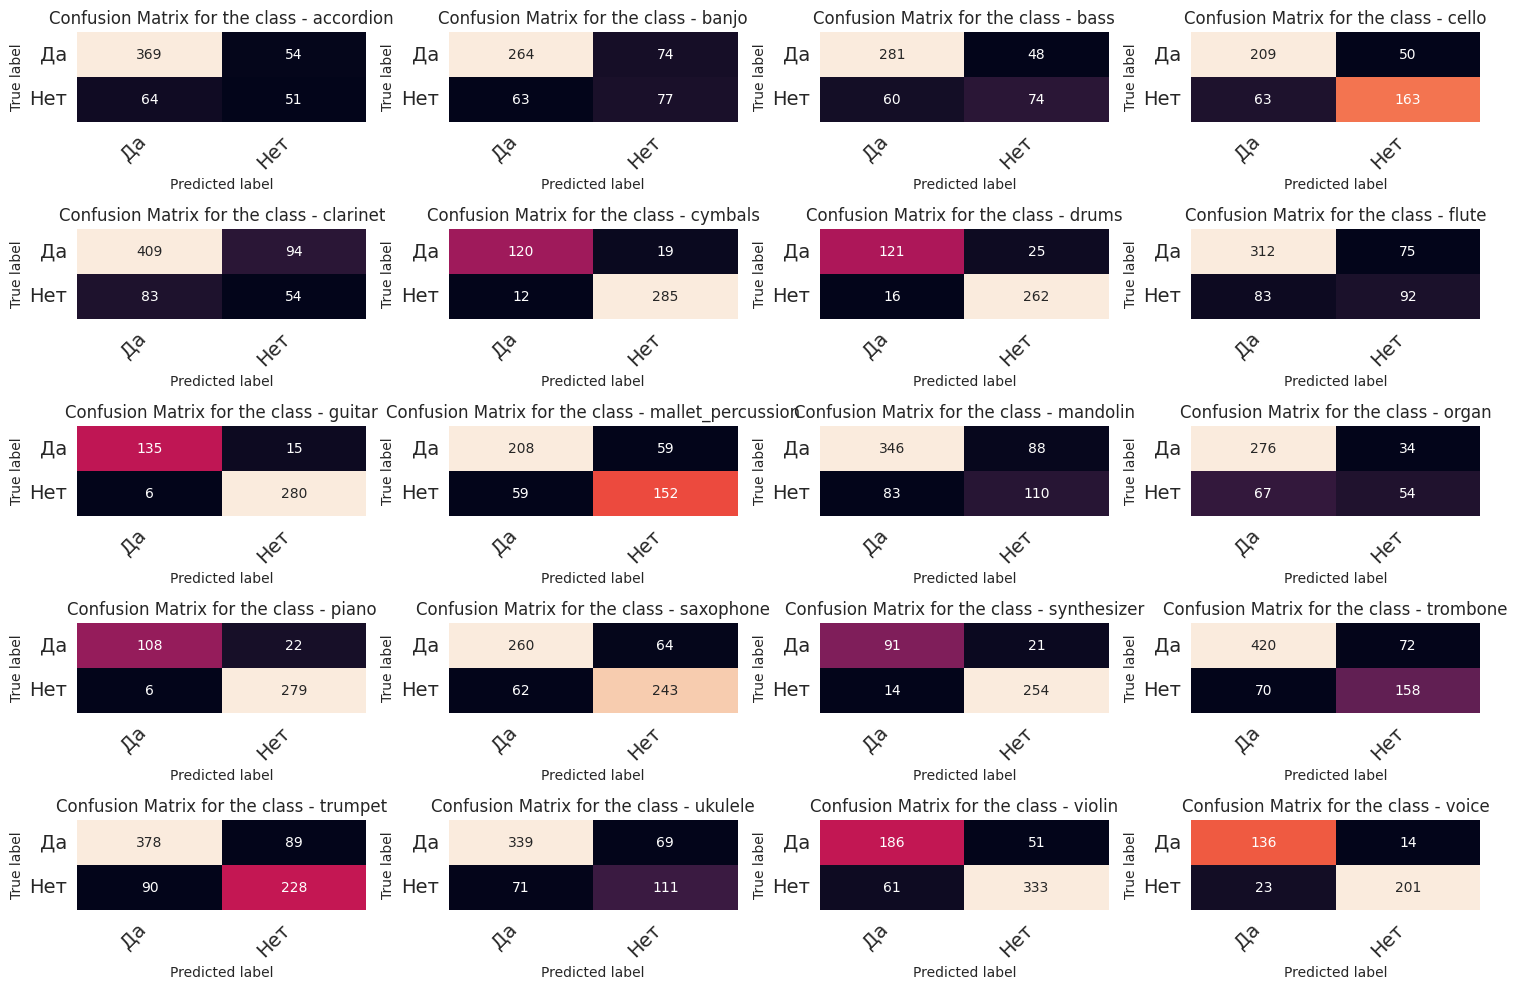

In [197]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = test_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

In [198]:
import xgboost as xgb

classifier = xgb.XGBClassifier(max_depth = 8, random_state=0)

models, \
    train_conf_matrices, \
    test_conf_matrices, \
    train_true_matrix, \
    train_pred_matrix, \
    test_true_matrix, \
    test_pred_matrix = classify(classifier)

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1159
        True       1.00      1.00      1.00       374

    accuracy                           1.00      1533
   macro avg       1.00      1.00      1.00      1533
weighted avg       1.00      1.00      1.00      1533

	TEST
              precision    recall  f1-score   support

       False       0.86      0.92      0.89       423
        True       0.60      0.44      0.51       115

    accuracy                           0.82       538
   macro avg       0.73      0.68      0.70       538
weighted avg       0.80      0.82      0.81       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1148
        True       1.00      1.00      1.00       592

    accuracy                           1

In [199]:
print('TRAIN')
m1 = squeeze_answer_matrix(train_true_matrix)
m2 = squeeze_answer_matrix(train_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

print('TEST')
m1 = squeeze_answer_matrix(test_true_matrix)
m2 = squeeze_answer_matrix(test_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TRAIN
Exact Match Ratio 1.0
Accuracy 1.0
TEST
Exact Match Ratio 0.695575221238938
Accuracy 0.7447295968534904


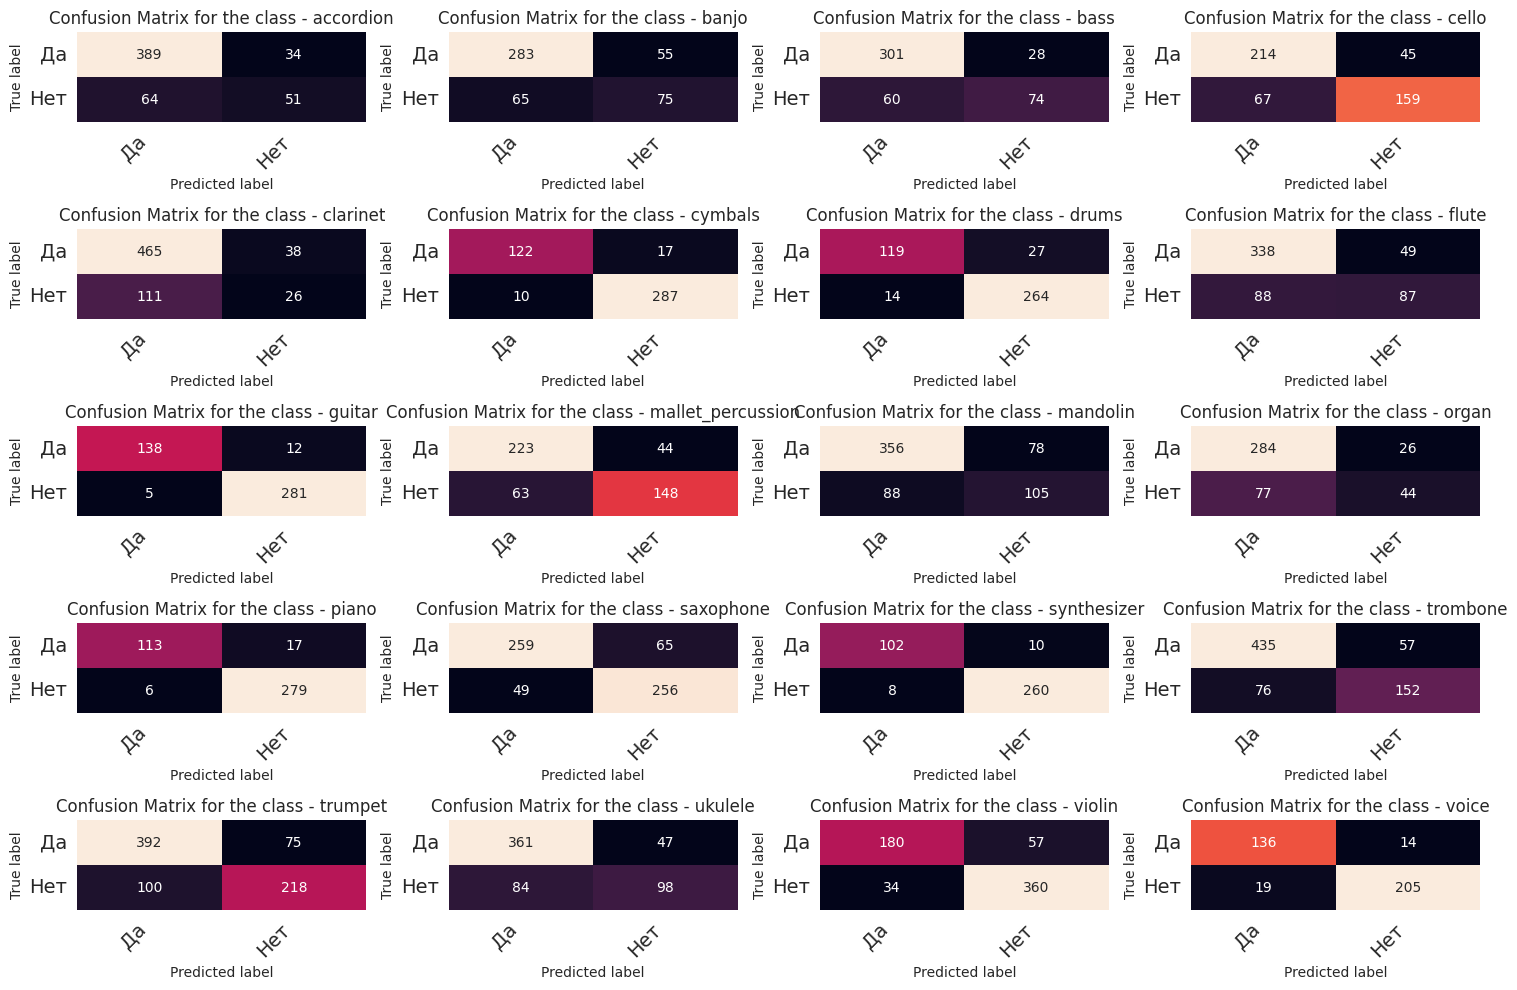

In [200]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = test_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

In [201]:
from catboost import CatBoostClassifier

class CustomCatBoostClassifier(CatBoostClassifier):
    def __init__(self):
        super().__init__(logging_level='Silent')

    def predict(self, data):
        prediction = super().predict(data)
        return prediction == 'True'


classifier = CustomCatBoostClassifier()

models, \
    train_conf_matrices, \
    test_conf_matrices, \
    train_true_matrix, \
    train_pred_matrix, \
    test_true_matrix, \
    test_pred_matrix = classify(classifier)

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1159
        True       1.00      0.99      1.00       374

    accuracy                           1.00      1533
   macro avg       1.00      1.00      1.00      1533
weighted avg       1.00      1.00      1.00      1533

	TEST
              precision    recall  f1-score   support

       False       0.84      0.95      0.89       423
        True       0.65      0.36      0.46       115

    accuracy                           0.82       538
   macro avg       0.75      0.65      0.68       538
weighted avg       0.80      0.82      0.80       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1148
        True       1.00      1.00      1.00       592

    accuracy                           1

In [202]:
print('TRAIN')
m1 = squeeze_answer_matrix(train_true_matrix)
m2 = squeeze_answer_matrix(train_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

print('TEST')
m1 = squeeze_answer_matrix(test_true_matrix)
m2 = squeeze_answer_matrix(test_pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TRAIN
Exact Match Ratio 0.9964465303385853
Accuracy 0.9973516594032852
TEST
Exact Match Ratio 0.7089478859390363
Accuracy 0.7559455916093085


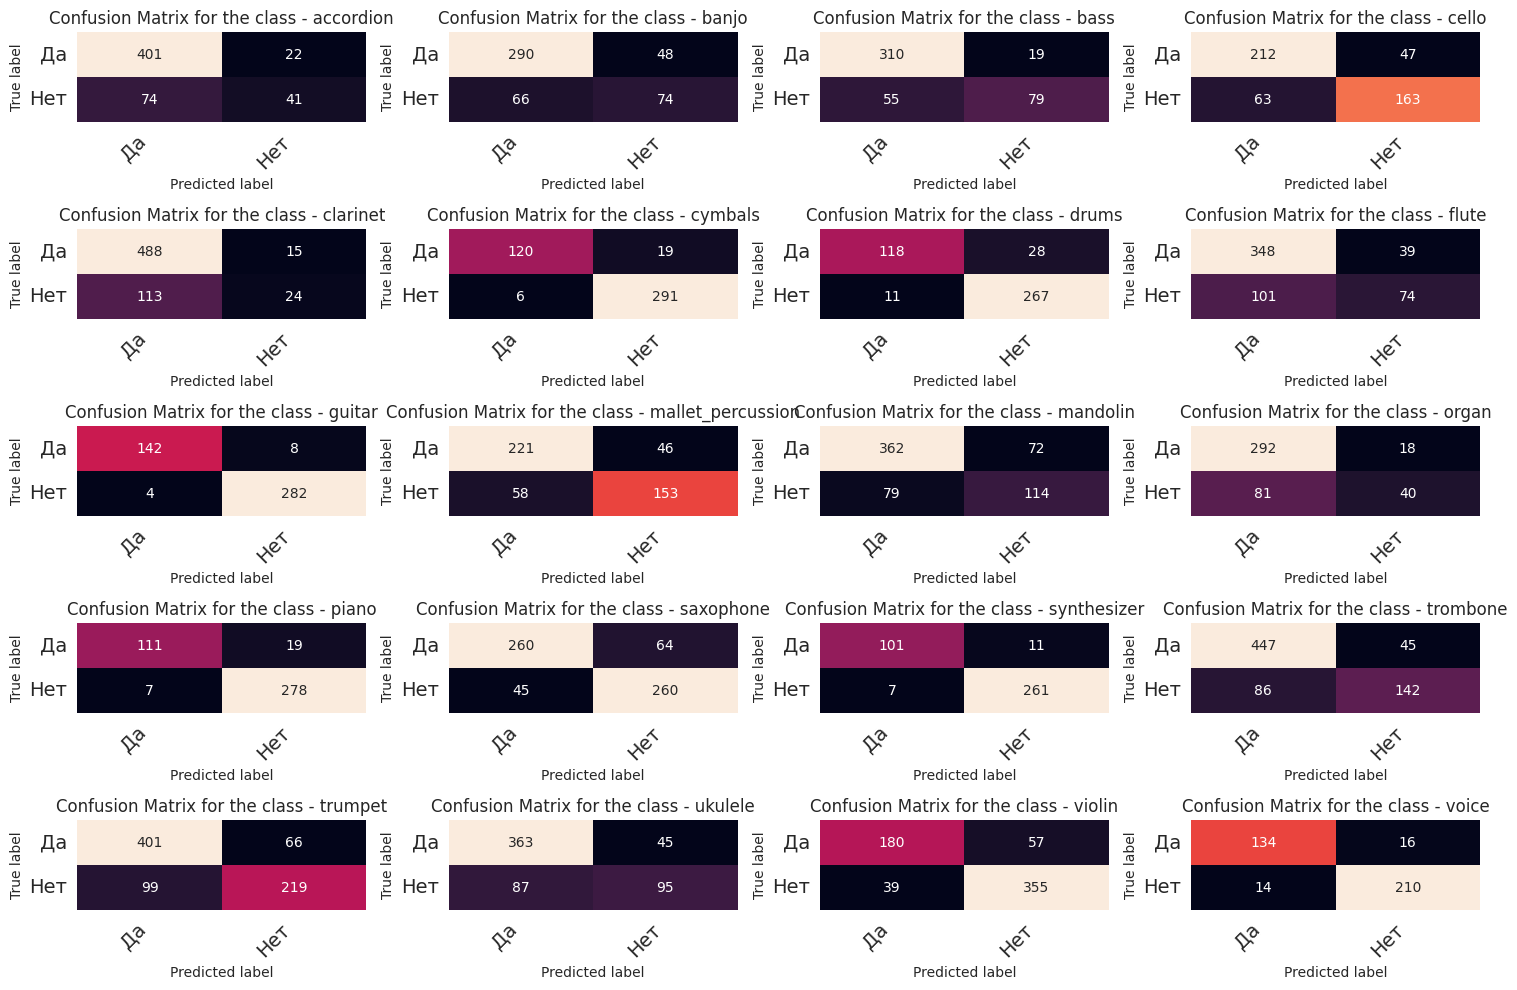

In [203]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = test_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

-----

In [204]:
# import torch
#
# model = torch.hub.load('harritaylor/torchvggish', 'vggish')
# model.eval()
# ;

In [205]:
# zxc = model.forward('data/test.mp3').cpu().detach().numpy()
# feature_mean = np.mean(zxc, axis=0, keepdims=True)
#
# for instrument in models:
#
#     clf = models[instrument]
#
#     print('P[{:18s}=1] = {:.3f}'.format(instrument, clf.predict_proba(feature_mean)[0,1]))